In [2]:
# Importing aLL important libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from paddle_quantum.hamiltonian import Hamiltonian
from paddle_quantum.QAOA.tsp import tsp_hamiltonian  # Get the Hamiltonian for salesman problem
from qiskit.tools.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,execute, Aer
# Solving a TSP with QAOA
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.primitives import Sampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
import numpy as np

C:\Users\syed afaan\anaconda3\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


[(0, 1, 5), (0, 2, 6), (1, 2, 7)]


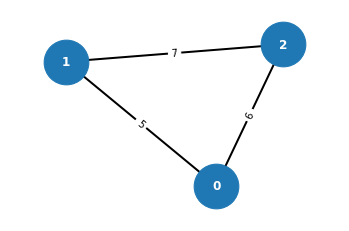

In [3]:
# Assume that you have a distance matrix called "distances"
# and a list of cities called "cities"

import networkx as nx
import matplotlib.pyplot as plt

# Define the distance matrix and list of cities
cities = [0,1,2]
distances=[[0,5,6], [5,0,7], [6,7,0]]

# Initialize an empty list to hold the edges and their weights
edges = []

# Iterate over the distance matrix and add edges to the list
for i in range(len(cities)):
    for j in range(i+1, len(cities)):
        if distances[i][j] != 0:
            edges.append((cities[i], cities[j], distances[i][j]))
print(edges)
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Print out the generated graph G
pos = nx.spring_layout(G)
options = {
    "with_labels": True,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G,'weight'))
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

    

    

In [4]:
# Construct the Hamiltonian H_C in the form of list -- with build-in function tsp_hamiltonian(G, A, n)
A = 46 # Penalty parameter
n = len(distances) # n is the number of vertices in the graph G
H_C_list = tsp_hamiltonian(G, A, n)
# Generate the Hamiltonian
#H_C =Hamiltonian(H_C_list)
print(H_C_list)
#cost_hamiltonian = H_C.construct_h_matrix()
#print((cost_hamiltonian),len(cost_hamiltonian))


[[1.25, 'i1'], [1.25, 'z0,z3'], [-1.25, 'z0'], [-1.25, 'z3'], [3.0, 'i1'], [-3.0, 'z1'], [3.0, 'i1'], [-3.0, 'z0'], [1.25, 'i1'], [1.25, 'z2,z1'], [-1.25, 'z2'], [-1.25, 'z1'], [3.5, 'i1'], [-3.5, 'z3'], [3.5, 'i1'], [-3.5, 'z2'], [46, 'i1'], [-46.0, 'i1'], [46.0, 'z0'], [23.0, 'i1'], [-23.0, 'z0'], [-46.0, 'i1'], [46.0, 'z1'], [23.0, 'i1'], [-23.0, 'z1'], [23.0, 'i1'], [23.0, 'z1,z0'], [-23.0, 'z1'], [-23.0, 'z0'], [46, 'i1'], [-46.0, 'i1'], [46.0, 'z2'], [23.0, 'i1'], [-23.0, 'z2'], [-46.0, 'i1'], [46.0, 'z3'], [23.0, 'i1'], [-23.0, 'z3'], [23.0, 'i1'], [23.0, 'z3,z2'], [-23.0, 'z3'], [-23.0, 'z2'], [46, 'i1'], [-46.0, 'i1'], [46.0, 'z0'], [23.0, 'i1'], [-23.0, 'z0'], [-46.0, 'i1'], [46.0, 'z2'], [23.0, 'i1'], [-23.0, 'z2'], [23.0, 'i1'], [23.0, 'z2,z0'], [-23.0, 'z2'], [-23.0, 'z0'], [46, 'i1'], [-46.0, 'i1'], [46.0, 'z1'], [23.0, 'i1'], [-23.0, 'z1'], [-46.0, 'i1'], [46.0, 'z3'], [23.0, 'i1'], [-23.0, 'z3'], [23.0, 'i1'], [23.0, 'z3,z1'], [-23.0, 'z3'], [-23.0, 'z1']]


In [5]:
from qiskit.quantum_info import SparsePauliOp
#The below code converts Paddle Pauli Z and I operator to Qiskit Pauli operator list.
coeff = []
term = []
for i in range(len(H_C_list)):
    
    co, te = H_C_list[i]
    te = te.upper()
    coeff.append(co)
    term.append(te)
# The to_qiskit_pauli(ops) function takes a list of Pauli operators extracted by the previous step 
#and converts that into Qiskit native pauli 
def to_qiskit_pauli(ops):
    qubits = set()
    for op in ops:
        qubits.update([int(q) for q in op[1:].replace(',', '') if q.isnumeric()])
    max_qubit = max(qubits) if len(qubits) > 0 else 0
    pauli_list = []
    for op in ops:
        pauli_str = ''
        q_indices = [int(q) for q in op[1:].replace(',', '') if q.isnumeric()]
        for q in range(max_qubit+1):
            pauli_char = 'I'
            if q in q_indices:
                pauli_char = op[0]
            pauli_str += pauli_char
        pauli_list.append(pauli_str)
    return pauli_list

qiskit_pauli_term = to_qiskit_pauli(term) # should give output in the form ['IIIZIIZII', 'IIIIIZIII']
#the below line zips botn coefficients and operators in one list
result = [(x, y) for x, y in zip(qiskit_pauli_term, coeff)]
print(result)



[('IIII', 1.25), ('ZIIZ', 1.25), ('ZIII', -1.25), ('IIIZ', -1.25), ('IIII', 3.0), ('IZII', -3.0), ('IIII', 3.0), ('ZIII', -3.0), ('IIII', 1.25), ('IZZI', 1.25), ('IIZI', -1.25), ('IZII', -1.25), ('IIII', 3.5), ('IIIZ', -3.5), ('IIII', 3.5), ('IIZI', -3.5), ('IIII', 46), ('IIII', -46.0), ('ZIII', 46.0), ('IIII', 23.0), ('ZIII', -23.0), ('IIII', -46.0), ('IZII', 46.0), ('IIII', 23.0), ('IZII', -23.0), ('IIII', 23.0), ('ZZII', 23.0), ('IZII', -23.0), ('ZIII', -23.0), ('IIII', 46), ('IIII', -46.0), ('IIZI', 46.0), ('IIII', 23.0), ('IIZI', -23.0), ('IIII', -46.0), ('IIIZ', 46.0), ('IIII', 23.0), ('IIIZ', -23.0), ('IIII', 23.0), ('IIZZ', 23.0), ('IIIZ', -23.0), ('IIZI', -23.0), ('IIII', 46), ('IIII', -46.0), ('ZIII', 46.0), ('IIII', 23.0), ('ZIII', -23.0), ('IIII', -46.0), ('IIZI', 46.0), ('IIII', 23.0), ('IIZI', -23.0), ('IIII', 23.0), ('ZIZI', 23.0), ('IIZI', -23.0), ('ZIII', -23.0), ('IIII', 46), ('IIII', -46.0), ('IZII', 46.0), ('IIII', 23.0), ('IZII', -23.0), ('IIII', -46.0), ('IIIZ', 4

In [6]:
Sparsed_Pauli= SparsePauliOp.from_list(result)
print(Sparsed_Pauli)

SparsePauliOp(['IIII', 'ZIIZ', 'ZIII', 'IIIZ', 'IIII', 'IZII', 'IIII', 'ZIII', 'IIII', 'IZZI', 'IIZI', 'IZII', 'IIII', 'IIIZ', 'IIII', 'IIZI', 'IIII', 'IIII', 'ZIII', 'IIII', 'ZIII', 'IIII', 'IZII', 'IIII', 'IZII', 'IIII', 'ZZII', 'IZII', 'ZIII', 'IIII', 'IIII', 'IIZI', 'IIII', 'IIZI', 'IIII', 'IIIZ', 'IIII', 'IIIZ', 'IIII', 'IIZZ', 'IIIZ', 'IIZI', 'IIII', 'IIII', 'ZIII', 'IIII', 'ZIII', 'IIII', 'IIZI', 'IIII', 'IIZI', 'IIII', 'ZIZI', 'IIZI', 'ZIII', 'IIII', 'IIII', 'IZII', 'IIII', 'IZII', 'IIII', 'IIIZ', 'IIII', 'IIIZ', 'IIII', 'IZIZ', 'IIIZ', 'IZII'],
              coeffs=[  1.25+0.j,   1.25+0.j,  -1.25+0.j,  -1.25+0.j,   3.  +0.j,  -3.  +0.j,
   3.  +0.j,  -3.  +0.j,   1.25+0.j,   1.25+0.j,  -1.25+0.j,  -1.25+0.j,
   3.5 +0.j,  -3.5 +0.j,   3.5 +0.j,  -3.5 +0.j,  46.  +0.j, -46.  +0.j,
  46.  +0.j,  23.  +0.j, -23.  +0.j, -46.  +0.j,  46.  +0.j,  23.  +0.j,
 -23.  +0.j,  23.  +0.j,  23.  +0.j, -23.  +0.j, -23.  +0.j,  46.  +0.j,
 -46.  +0.j,  46.  +0.j,  23.  +0.j, -23.  +0.j, -46. 

In [13]:
# Solving a TSP with QAOA
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.primitives import Sampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import numpy as np

# To run the QAOA we need:
# 1. The cost function / Hamiltonian => a function that encodes the problem we want to solve. The solution to our problem should be the lowest value of the cost function.
# 2. A parameterized circuit (ansatz) => a circuit that has some parameters that we can change. The parameters are the ones that we will optimize.
# 3. The optimizer => a function that "knows" how to search for the best parameters.
# 4. The sampler => a way to run the circuit and get the results. This is the backend which can be a simulator or a real quantum computer.

# #### --- 1. The cost function.
# The cost function takes a "solution" as input and returns the cost of that solution. The lower the cost the better the solution.
# For quantum algorithms, the cost function is usually a Hamiltonian. We have to define a Hamiltonian that encodes our problem.
# A Hamiltonian acts on a quantum state and returns the state's energy. Thus, the lowest energy state is the best solution to our problem.
# In general this is the most difficult part of the problem. We need to find a good way to encode our problem using quantum states and a Hamiltonian.
# As we've discussed the general idea is to encode a solution as a bitstring "00110101..." and then encode the bistring to a quantum state.
# This results in a Hamiltonian that can be represented either as an operator object or as a matrix.

# The main difficulty of your work is to create a function that takes as input the "cost matrix" of the cities and returns the Hamiltonian operator or matrix:
cost_matrix = np.array([[0,45,20,5], [45,0,35,25], [20,35,0,30], [5,25,30,0]])
def cost_matrix_to_hamiltonian(cost_matrix):
    
    '''num_cities = len(cost_matrix)
    pauli_terms = []
    constant = 0
    for i in range(num_cities):
        for j in range(i):
            if i != j:
                # We need to create a Pauli term for each pair of cities.
                # Each Pauli term will correspond to the interaction between two qubits.
                # We'll use the formula from https://arxiv.org/pdf/1709.03489.pdf.
                coefficient = cost_matrix[i,j]/2
                pauli_string = 'I'*num_cities
                pauli_string = pauli_string[:i] + 'Z' + pauli_string[i+1:]
                pauli_string = pauli_string[:j] + 'Z' + pauli_string[j+1:]
                pauli_terms.append((pauli_string, coefficient))
                constant += coefficient
    # Finally, we create the Hamiltonian by adding all the Pauli terms and the constant.
    hamiltonian = SparsePauliOp.from_list(pauli_terms)
    hamiltonian.chop(10**-10)
    #hamiltonian = hamiltonian.to_matrix() + constant*np.eye(2**num_cities)
    return hamiltonian'''

#tsp_cost_h = cost_matrix_to_hamiltonian(cost_matrix)
#print(tsp_cost_h )
tsp_cost_h = Sparsed_Pauli # Using the list which we made in previous step
print(tsp_cost_h )

# #### --- 2. The ansatz.
# We need to define a parameterized circuit. It can be anything we want. Of course, we want the circuit to be a good approximation of the solution to our problem.
# For now we skip this step and use the default ansatz of QAOA provided by Qiskit.

# #### --- 3. The optimizer.
# To improve the initial (random) parameters of the circuit we need to define an optimizer.
# COBYLA is a good start for QAOA.
optimizer = COBYLA()

# #### --- 4. The sampler. There are many ways to access simulators and real q devices. qiskit's `primitives` is one of them (rather new and perhaps recommended).
sampler = Sampler()


# ### RUN and get the results

# Now to define and run the circuit.
qaoa = QAOA(sampler, optimizer)

# Run the circuit multiple times to find the best parameters.
result = qaoa.compute_minimum_eigenvalue(tsp_cost_h)
#ckt =  qaoa.dir()
#print(ckt)
# Show the state with the lowest energy.
print(result.eigenstate)
optimal_cost = result.eigenvalue.real # get the real part of the eigenvalue
print('optimal_cost',optimal_cost)
print(qaoa)
print(dir(qaoa))
print(result)



SparsePauliOp(['IIII', 'ZIIZ', 'ZIII', 'IIIZ', 'IIII', 'IZII', 'IIII', 'ZIII', 'IIII', 'IZZI', 'IIZI', 'IZII', 'IIII', 'IIIZ', 'IIII', 'IIZI', 'IIII', 'IIII', 'ZIII', 'IIII', 'ZIII', 'IIII', 'IZII', 'IIII', 'IZII', 'IIII', 'ZZII', 'IZII', 'ZIII', 'IIII', 'IIII', 'IIZI', 'IIII', 'IIZI', 'IIII', 'IIIZ', 'IIII', 'IIIZ', 'IIII', 'IIZZ', 'IIIZ', 'IIZI', 'IIII', 'IIII', 'ZIII', 'IIII', 'ZIII', 'IIII', 'IIZI', 'IIII', 'IIZI', 'IIII', 'ZIZI', 'IIZI', 'ZIII', 'IIII', 'IIII', 'IZII', 'IIII', 'IZII', 'IIII', 'IIIZ', 'IIII', 'IIIZ', 'IIII', 'IZIZ', 'IIIZ', 'IZII'],
              coeffs=[  1.25+0.j,   1.25+0.j,  -1.25+0.j,  -1.25+0.j,   3.  +0.j,  -3.  +0.j,
   3.  +0.j,  -3.  +0.j,   1.25+0.j,   1.25+0.j,  -1.25+0.j,  -1.25+0.j,
   3.5 +0.j,  -3.5 +0.j,   3.5 +0.j,  -3.5 +0.j,  46.  +0.j, -46.  +0.j,
  46.  +0.j,  23.  +0.j, -23.  +0.j, -46.  +0.j,  46.  +0.j,  23.  +0.j,
 -23.  +0.j,  23.  +0.j,  23.  +0.j, -23.  +0.j, -23.  +0.j,  46.  +0.j,
 -46.  +0.j,  46.  +0.j,  23.  +0.j, -23.  +0.j, -46. 

INFO 2023-04-08 14:10:40,205 sampling_vqe.py:230] Optimization complete in 13.260785341262817 seconds.
Found opt_params [-4.29499641 -4.59222947].


{0: 0.0326973117759171, 1: 0.0758882913030089, 2: 0.0758882913030088, 3: 0.0226961786544109, 4: 0.0297658895074733, 5: 0.0143385814692238, 6: 0.142995795910112, 7: 0.0167795688812784, 8: 0.0297658895074732, 9: 0.142995795910112, 10: 0.0143385814692238, 11: 0.0167795688812784, 12: 0.093806729272249, 13: 0.112636649966264, 14: 0.1126366499662641, 15: 0.0659902262227001}
optimal_cost 91.77291861059818
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_sampling_vqe_result', '_check_operator_ansatz', '_cost_operator', '_get_evaluate_energy', '_initial_point', 'aggregation', 'ansatz', 'callback', 'compute_minimum_eigenvalue', 'initial_point', 'ini